### One-Hot-Encoding Keras

In [1]:
from keras.preprocessing.text import Tokenizer

samples = ['The cat sat on the mat.', 'The dog ate my homework.']
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9 unique tokens.


In [2]:
word_index

{'the': 1,
 'cat': 2,
 'sat': 3,
 'on': 4,
 'mat': 5,
 'dog': 6,
 'ate': 7,
 'my': 8,
 'homework': 9}

## Using word embeddings
Another popular and powerful way to associate a vector with a word is the use of dense
word vectors, also called word embeddings. Whereas the vectors obtained through one-hot
encoding are binary, sparse (mostly made of zeros), and very high-dimensional (same
dimensionality as the number of words in the vocabulary), word embeddings are low-
dimensional floating-point vectors (that is, dense vectors, as opposed to sparse vec-
tors); see figure 6.2. Unlike the word vectors obtained via one-hot encoding, word
embeddings are learned from data. It’s common to see word embeddings that are
256-dimensional, 512-dimensional, or 1,024-dimensional when dealing with very large
vocabularies. On the other hand, one-hot encoding words generally leads to vectors
that are 20,000-dimensional or greater (capturing a vocabulary of 20,000 tokens, in
this case). So, word embeddings pack more information into far fewer dimensions.

There are two ways to obtain word embeddings:
* Learn word embeddings jointly with the main task you care about (such as document classification or sentiment prediction). In this setup, you start with random word vectors and then learn word vectors in the same way you learn the weights of a neural network.
* Load into your model word embeddings that were precomputed using a different machine-learning task than the one you’re trying to solve. These are called pretrained word embeddings.

### Keras Embedding Layer
We want to earn an embedding space with every new task. An embedding space is a series of vectors which are able to map words to some other words. Example:

* ```cat -> tiger``` is the same vector that maps  ```dog -> wolf``` and we can call it **wild transformator**;
* ```king -> queen``` is the same vector that maps  ```actor -> actress``` and we can call it **gender transformator**;

Fortunately, backpropagation makes this easy, and Keras makes it even easier. It’s about learning the weights of a layer: the Embedding layer.

The Embedding layer is best understood as a dictionary that maps integer indices
(which stand for specific words) to dense vectors. It takes integers as input, it looks up
these integers in an internal dictionary, and it returns the associated vectors. It’s effectively a dictionary lookup (see figure 6.4).

In [3]:
# arguments: number of possible tokens and dimensionality of the embeddings

from keras.layers import Embedding
embedding_layer = Embedding(1000, 64)

The Embedding layer takes as input a 2D tensor of integers, of shape (samples,
sequence_length) , where each entry is a sequence of integers. It can embed
sequences of variable lengths: for instance, you could feed into the Embedding layer in
the previous example batches with shapes (32, 10) (batch of 32 sequences of length
10) or (64, 15) (batch of 64 sequences of length 15). All sequences in a batch must
have the same length, though (because you need to pack them into a single tensor),
so sequences that are shorter than others should be padded with zeros, and sequences
that are longer should be truncated.
This layer returns a 3D floating-point tensor of shape (samples, sequence_
length, embedding_dimensionality) . Such a 3D tensor can then be processed by
an RNN layer or a 1D convolution layer (both will be introduced in the following
sections).
When you instantiate an Embedding layer, its weights (its internal dictionary of
token vectors) are initially random, just as with any other layer. During training, these
word vectors are gradually adjusted via backpropagation, structuring the space into
something the downstream model can exploit. Once fully trained, the embedding
space will show a lot of structure—a kind of structure specialized for the specific prob-
lem for which you’re training your model.

Let’s apply this idea to the IMDB movie-review sentiment-prediction task that
you’re already familiar with. First, you’ll quickly prepare the data. You’ll restrict the
movie reviews to the top 10,000 most common words (as you did the first time you
worked with this dataset) and cut off the reviews after only 20 words. The network will
learn 8-dimensional embeddings for each of the 10,000 words, turn the input integer sequences (2D integer tensor) into embedded sequences ( 3D float tensor), flatten the
tensor to 2D, and train a single Dense layer on top for classification.

In [5]:
from keras.datasets import imdb
from keras import preprocessing

# Number of words to consider as features
max_features = 10000

# Cuts off the text after this number of words (among the max_features most common words)
maxlen = 20

# Loads the data as lists of integers
(x_train, y_train), (x_test, y_test) = imdb.load_data(
    num_words=max_features)

# Turns the lists of integers into a 2D integer tensor of shape (samples, maxlen)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [6]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()

# Specifies the maximum input length to the Embedding layer so you can later flatten the 
# embedded inputs. After the Embedding layer, the activations have shape (samples, maxlen, 8).
model.add(Embedding(10000, 8, input_length=maxlen))
# Flattens the 3D tensor of embeddings into a 2D tensor of shape (samples, maxlen * 8)
model.add(Flatten())
# Adds the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = model.fit(x_train, 
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 1s 2ms/step - loss: 0.6692 - acc: 0.6145 - val_loss: 0.6156 - val_acc: 0.6990
Epoch 2/10
625/625 [==============================] - 1s 1ms/step - loss: 0.5375 - acc: 0.7525 - val_loss: 0.5229 - val_acc: 0.7322
Epoch 3/10
625/625 [==============================] - 1s 1ms/step - loss: 0.4604 - acc: 0.7862 - val_loss: 0.5005 - val_acc: 0.7460
Epoch 4/10
625/625 [==============================] - 1s 1ms/step - loss: 0.4246 - acc: 0.8065 - val_loss: 0.4939 - val_acc: 0.7518
Epoch 5/10
625/625 [==============================] - 1s 1ms/step - loss: 0.3998 - acc: 0.8203 - val_loss: 0.4946 - val_acc: 0.7600
Epoch 6/10
625/625 [==============================] - 1s 1ms/step - loss: 0.3796 - acc: 0.8314 - val_loss: 0.4967 - val_acc: 0.7588
Epoch 7/10
625/625 [==============================] - 1s 1ms/step - loss: 0.3609 - acc: 0.8439 - val_loss: 0.5007 - val_acc: 0.7558
Epoch 8/10
625/625 [==============================] - 1s 1ms/step - loss: 0.

### DOWNLOADING THE IMDB DATA AS RAW TEXT

In [1]:
import os

imdb_dir = "./Dataset/aclImdb"
train_dir = os.path.join(imdb_dir, 'train')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)


In [2]:
texts[0]

'I am quite a fan of novelist/screenwriter Michael Chabon. His novel "Wonder Boys" became a fantastic movie by Curtis Hanson. His masterful novel "The Amazing Adventures of Kavalier and Clay" won the Pulitzer Prize a few years back, and he had a hand in the script of "Spider Man 2", arguably the greatest comic book movie of all time.<br /><br />Director Rawson Marshall Thurber has also directed wonderful comedic pieces, such as the gut-busting "Dodgeball" and the genius short film series "Terry Tate: Office Linebacker". And with a cast including Peter Saarsgard, Sienna Miller, Nick Nolte and Mena Suvari, this seems like a no-brainer.<br /><br />It is. Literally.<br /><br />Jon Foster stars as Art Bechstein, the son of a mobster (Nolte) who recently graduated with a degree in Economics. Jon is in a state of arrested development: he works a minimum wage job at Book Barn, has a vapid relationship with his girlfriend/boss, Phlox (Suvari), which amounts to little more than copious amounts o

In [22]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# Cuts off reviews after 100 words
maxlen = 100

# Trains on 200 samples
training_samples = 200

# Validates on 10,000 samples
validation_samples = 10000

# Considers only the top 10,000 words in the dataset
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen = maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Splits the data into a training set and a validation set, but first shuffles the data,
# because you’re starting with data in which samples are ordered (all negative first, then all positive)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Found 88582 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


#### Sequence padding meaning
pad_sequences(array di parole, maxlen = x) ritorna un numpy vector di dim (len(array di parole), maxlen)

* x è la lunghezza massima: <br>
  se ho un'istanza più lunga viene troncata dopo x parole, se più corta vengono messi 0 all'inizio
* maxlen = None -> prende lunghezza dell'istanza più lunga dell'array

In [21]:
print(sequences[0])
print()
print(str(pad_sequences(sequences, maxlen = maxlen)[0]) + '\n' +
     str(pad_sequences(sequences, maxlen = maxlen)[1]))

[10, 241, 176, 3, 334, 4, 7799, 2974, 485, 24, 664, 591, 1009, 874, 3, 774, 17, 31, 3366, 24, 4760, 664, 1, 477, 2471, 4, 2, 7180, 1196, 1, 4483, 3, 168, 150, 142, 2, 26, 66, 3, 505, 8, 1, 226, 4, 5034, 129, 238, 4676, 1, 830, 695, 271, 17, 4, 29, 55, 7, 7, 164, 5340, 44, 79, 523, 386, 1714, 1321, 138, 14, 1, 5558, 2, 1, 1257, 343, 19, 198, 3950, 1048, 2, 16, 3, 174, 583, 823, 3084, 1848, 6192, 2, 11, 183, 37, 3, 54, 7, 7, 9, 6, 1224, 7, 7, 2633, 2888, 378, 14, 495, 1, 489, 4, 3, 8595, 6192, 34, 1028, 16, 3, 2454, 8, 2633, 6, 8, 3, 1105, 4, 3537, 939, 26, 492, 3, 4892, 289, 30, 271, 44, 3, 7916, 646, 16, 24, 976, 1407, 60, 4632, 5, 114, 50, 71, 4632, 4, 380, 16, 54, 2455, 82, 71, 5, 8169, 242, 30, 3, 608, 15, 60, 26, 44, 1453, 1794, 7, 7, 28, 311, 30, 3, 1069, 32, 1230, 5283, 4311, 2633, 5, 1011, 3084, 3, 304, 1389, 300, 12, 311, 33, 137, 43, 15, 3264, 2, 56, 1640, 2633, 3, 884, 12, 775, 5, 4449, 87, 36, 24, 1105, 4, 2006, 10, 178, 22, 5, 373, 69, 139, 12, 22, 25, 112, 576, 3, 682, 135

## Using Glove Embeddings to add embedding weight to the model

In [25]:
# Gli embedding sono salvati nel .txt uno per riga come: <parola> [<dati>] 

glove_dir = './Dataset/glove'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Next, you’ll build an embedding matrix that you can load into an Embedding layer. It
must be a matrix of shape (max_words, embedding_dim) , where each entry i contains
the embedding_dim -dimensional vector for the word of index i in the reference word
index (built during tokenization). Note that index 0 isn’t supposed to stand for any
word or token — it’s a placeholder.

Nel nostro caso la matrice sarà (100 x 100) perché abbiamo un massimo di 100 parole e embedding di dimensione 100

In [27]:
# Creo la mia matrice per ogni parola del mio dizionario e metto la riga della matrice a tutti 0 se non
# esiste una certa parola
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        # Words not found in the embedding index will be all zeros.
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [28]:
# Mi costruisco il modello

from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Modifico i weights del primo layer (Embedding), mettendo la matrice calcolata con Glove
# Metto che questo layer non viene allenato, ma usa i pesi indicati nella prima riga di codice

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [30]:
# Ora compilo e alleno il modello
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 1s 151ms/step - loss: 1.0562 - acc: 0.5050 - val_loss: 0.6932 - val_acc: 0.5047
Epoch 2/10
7/7 [==============================] - 1s 123ms/step - loss: 0.7161 - acc: 0.5900 - val_loss: 0.6936 - val_acc: 0.5012
Epoch 3/10
7/7 [==============================] - 1s 126ms/step - loss: 0.6116 - acc: 0.6450 - val_loss: 0.7145 - val_acc: 0.5000
Epoch 4/10
7/7 [==============================] - 1s 138ms/step - loss: 0.6775 - acc: 0.7200 - val_loss: 0.7207 - val_acc: 0.4994
Epoch 5/10
7/7 [==============================] - 1s 122ms/step - loss: 0.3846 - acc: 0.8900 - val_loss: 0.7413 - val_acc: 0.5065
Epoch 6/10
7/7 [==============================] - 1s 122ms/step - loss: 0.2822 - acc: 0.9700 - val_loss: 0.8627 - val_acc: 0.5056
Epoch 7/10
7/7 [==============================] - 1s 122ms/step - loss: 0.3094 - acc: 0.8600 - val_loss: 0.7516 - val_acc: 0.4987
Epoch 8/10
7/7 [==============================] - 1s 121ms/step - loss: 0.1664 - acc: 1.00

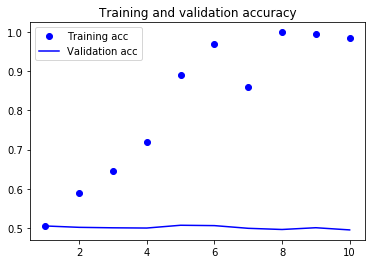

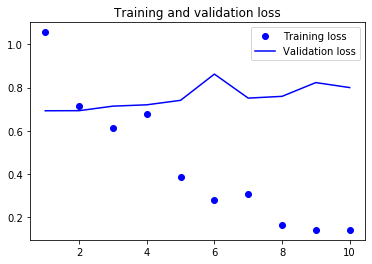

In [31]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Se provassimo a fare un Embedding allenandolo sul modello con così pochi sample avremmo un' accuracy più bassa del modello con gli Embedding preallenati, ma se aumentassimo il numero di istanze del modello avremmo un'accuracy migliore

### Tokenizing the data of the test

In [32]:
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
                
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [33]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 3s 4ms/step - loss: 0.8108 - acc: 0.4900


[0.8107941150665283, 0.49004000425338745]

# Recurring Neural Network (RNN)
Prende lo stato dell'iterazione precedente ogni volta
``` python
state_t = 0
for input_t in input_sequence:
    # Usiamo una RELU activation
    output_t = activation(dot(W, input_t) + dot(U, state_t) + b)
    state_t = output_t
```

In [1]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

# Metodo per ritornare l'output dell'ultimo timestep

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          320000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


In [2]:
# Metodo per ritornare tutti i timestep

model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


It’s sometimes useful to stack several recurrent layers one after the other in order to
increase the representational power of a network. In such a setup, you have to get all
of the intermediate layers to return full sequence of outputs:

In [3]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
# Last layer only returns the last output
model.add(SimpleRNN(32))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


On the IMBD Dataset

In [4]:
from keras.datasets import imdb
from keras.preprocessing import sequence

# Number of words to consider as features
max_features = 10000

# Cuts off texts after this many words (among the max_features most common words)
maxlen = 500
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(
    num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')
print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [5]:
from keras.layers import Dense
model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 17s 110ms/step - loss: 0.6082 - acc: 0.6496 - val_loss: 0.5376 - val_acc: 0.7416
Epoch 2/10
157/157 [==============================] - 18s 113ms/step - loss: 0.3885 - acc: 0.8355 - val_loss: 0.4130 - val_acc: 0.8270
Epoch 3/10
157/157 [==============================] - 18s 115ms/step - loss: 0.2842 - acc: 0.8882 - val_loss: 0.3362 - val_acc: 0.8628
Epoch 4/10
157/157 [==============================] - 19s 121ms/step - loss: 0.2180 - acc: 0.9175 - val_loss: 0.3904 - val_acc: 0.8376
Epoch 5/10
157/157 [==============================] - 17s 109ms/step - loss: 0.1648 - acc: 0.9397 - val_loss: 0.3897 - val_acc: 0.8516
Epoch 6/10
157/157 [==============================] - 17s 109ms/step - loss: 0.1136 - acc: 0.9606 - val_loss: 0.4377 - val_acc: 0.8282
Epoch 7/10
157/157 [==============================] - 17s 109ms/step - loss: 0.0736 - acc: 0.9765 - val_loss: 0.5141 - val_acc: 0.8268
Epoch 8/10
157/157 [==============================] - 1

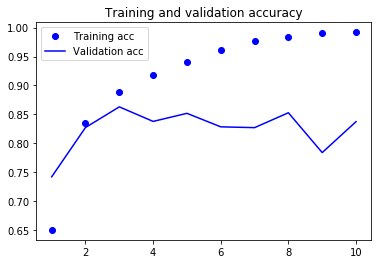

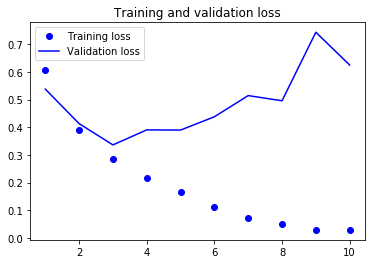

In [6]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

RNN has access to less information than the earlier baseline model. The remainder of
the problem is that SimpleRNN isn’t good at processing long sequences, such as text.


Other types of recurrent layers perform much better. Let’s look at some more-
advanced layers.

### LSMT
This layer is a variant of the SimpleRNN layer you already know about; it adds a way
to carry information across many timesteps. Imagine a conveyor belt running parallel
to the sequence you’re processing. Information from the sequence can jump onto the
conveyor belt at any point, be transported to a later timestep, and jump off, intact,
when you need it. This is essentially what LSTM does: it saves information for later,
thus preventing older signals from gradually vanishing during processing.

In [7]:
from keras.datasets import imdb
from keras.preprocessing import sequence

# Number of words to consider as features
max_features = 10000

# Cuts off texts after this many words (among the max_features most common words)
maxlen = 500
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(
    num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')
print('Pad sequences (samples x time)')
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


In [8]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 35s 221ms/step - loss: 0.5088 - acc: 0.7636 - val_loss: 0.3450 - val_acc: 0.8642
Epoch 2/10
157/157 [==============================] - 34s 219ms/step - loss: 0.2999 - acc: 0.8804 - val_loss: 0.3037 - val_acc: 0.8714
Epoch 3/10
157/157 [==============================] - 34s 219ms/step - loss: 0.2355 - acc: 0.9107 - val_loss: 0.3118 - val_acc: 0.8718
Epoch 4/10
157/157 [==============================] - 34s 216ms/step - loss: 0.2017 - acc: 0.9240 - val_loss: 0.3723 - val_acc: 0.8720
Epoch 5/10
157/157 [==============================] - 34s 216ms/step - loss: 0.1752 - acc: 0.9380 - val_loss: 0.2857 - val_acc: 0.8826
Epoch 6/10
157/157 [==============================] - 35s 224ms/step - loss: 0.1563 - acc: 0.9426 - val_loss: 0.3192 - val_acc: 0.8778
Epoch 7/10
157/157 [==============================] - 35s 222ms/step - loss: 0.1398 - acc: 0.9506 - val_loss: 0.4891 - val_acc: 0.8558
Epoch 8/10
157/157 [==============================] - 3

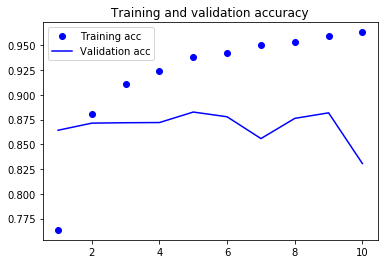

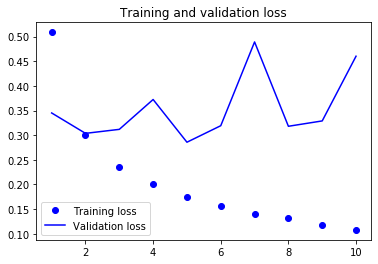

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Why isn’t LSTM performing better? One reason is that you made no effort
to tune hyperparameters such as the embeddings dimensionality or the LSTM output
dimensionality. Another may be lack of regularization. But honestly, the primary rea-
son is that analyzing the global, long-term structure of the reviews (what LSTM is good
at) isn’t helpful for a sentiment-analysis problem. Such a basic problem is well solved
by looking at what words occur in each review, and at what frequency. That’s what the
first fully connected approach looked at. But there are far more difficult natural-
language-processing problems out there, where the strength of LSTM will become
apparent: in particular, question-answering and machine translation.

# Inspecting and Monitoring Models

Here are some examples of ways you can use callbacks:
* Model checkpointing—Saving the current weights of the model at different points
during training.
* Early stopping—Interrupting training when the validation loss is no longer
improving (and of course, saving the best model obtained during training).
* Dynamically adjusting the value of certain parameters during training—Such as the
learning rate of the optimizer.
* Logging training and validation metrics during training, or visualizing the representations learned by the model as they’re updated—The Keras progress bar that you’re familiar with is a callback!

The ```keras.callbacks module``` includes a number of built-in callbacks (this is not an exhaustive list):
* ```keras.callbacks.ModelCheckpoint```
* ```keras.callbacks.EarlyStopping```
* ```keras.callbacks.LearningRateScheduler```
* ```keras.callbacks.ReduceLROnPlateau```
* ```keras.callbacks.CSVLogger```

In [23]:
from keras.datasets import imdb
from keras import preprocessing

# Number of words to consider as features

# Cuts off the text after this number of words (among the max_features most common words)

# Loads the data as lists of integers
(x_train, y_train), (x_test, y_test) = imdb.load_data()

# Turns the lists of integers into a 2D integer tensor of shape (samples, maxlen)
x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=None)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=None)

In [32]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()

print(len(x_train))
print(len(x_train[0]))

# Specifies the maximum input length to the Embedding layer so you can later flatten the 
# embedded inputs. After the Embedding layer, the activations have shape (samples, maxlen, 8).
model.add(Embedding(len(x_train), 8, input_length=len(x_train[0])))
# Flattens the 3D tensor of embeddings into a 2D tensor of shape (samples, maxlen * 8)
model.add(Flatten())
# Adds the classifier on top
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

25000
2494
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 2494, 8)           200000    
_________________________________________________________________
flatten_6 (Flatten)          (None, 19952)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 19953     
Total params: 219,953
Trainable params: 219,953
Non-trainable params: 0
_________________________________________________________________


In [33]:
import keras

# Callbacks are passed to the model via the callbacks argument in fit, which takes a list of
# callbacks. You can pass any number of callbacks.
callbacks_list = [
#Interrupts training when improvement stops
    keras.callbacks.EarlyStopping(
        #Monitors the model’s validation accuracy
        monitor='acc',
        #Interrupts training when accuracy has stopped improving for more than one epoch (that is, two epochs)
        patience=1
    ),
    #Saves the current weights after every epoch
    keras.callbacks.ModelCheckpoint(
        #Path to the destination model file
        filepath='my_model.h5',
        #These two arguments mean you won’t overwrite the model file unless val_loss has improved, which allows
        #you to keep the best model seen during training.
        monitor='val_loss',
        save_best_only=True
    ),
        
    keras.callbacks.ReduceLROnPlateau(
        #Monitors the model’s validation loss
        monitor='val_loss',
        #Divides the learning rate by 10 when triggered
        factor=0.1,
        #The callback is triggered after the validation loss has stopped improving for 10 epochs.
        patience=10,
    )
]

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              # You monitor accuracy, so it should be part of the model’s metrics.
              metrics=['acc'])

#Note that because the callback will monitor validation loss and validation accuracy, you need to pass
#validation_data to the call to fit.
history = model.fit(x_train, y_train,
          epochs=20,
          batch_size=32,
          callbacks=callbacks_list,
          validation_data=(x_test, y_test))

Epoch 1/20


InvalidArgumentError:  indices[10,2317] = 33805 is not in [0, 25000)
	 [[node sequential_11/embedding_11/embedding_lookup (defined at <ipython-input-33-955fc860eb9c>:44) ]] [Op:__inference_train_function_214053]

Errors may have originated from an input operation.
Input Source operations connected to node sequential_11/embedding_11/embedding_lookup:
 sequential_11/embedding_11/embedding_lookup/213820 (defined at /home/spola/anaconda3/lib/python3.7/contextlib.py:112)

Function call stack:
train_function


In [22]:
model.load_weights('my_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 1s 795us/step - loss: 1.0342 - acc: 0.6962


[1.034183144569397, 0.6962000131607056]